In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

### Understanding missing values

In [3]:
print(df.shape)
print(df.isnull().sum(axis=0))

(31875, 12)
runDate                 0
stations                0
trainCode               0
trainStationId          0
scheduledArrival      691
scheduledDeparture    778
actualArrival           0
actualDeparture       100
distance                0
dayCount                0
ArrivalDelay            0
DepartureDelay          0
dtype: int64


NaNs in scheduledArrival probably correspond to starting stations and NaNs in scheduledDeparture correspond to ending points. But ideally #starting-stations should be equal to #ending-stations.

This points out the possibility of slip-coaches. Let's check the number of unique end-points which should be equal to number trains.

In [4]:
print("Number of unique trains \t\t", len(df["trainCode"].unique()))
print("Number of unqiue terminating points \t", \
      df.loc[(df["scheduledDeparture"].isnull())][["stations", "trainCode"]].drop_duplicates().shape[0])

Number of unique trains 		 15
Number of unqiue terminating points 	 17


**This confirms the presence of slip-coaches cases. Let's explore which trains have multiple terminating points.**

In [5]:
df_end_pts = df.loc[(df["scheduledDeparture"].isnull())][["stations", "trainCode"]].drop_duplicates()
df_end_pts[df_end_pts.duplicated(subset="trainCode", keep=False)]

,stations,trainCode
2684,NGP,12139
2691,BPQ,12139
30064,KLK,12925
30070,ASR,12925


**We noticed the trainCode 12139 and 12925 has two end-points.** \

### Check actualArrival values when scheduledArrival is NaN 

In [6]:
df.loc[df["scheduledArrival"].isnull(), ["actualArrival", "ArrivalDelay"]]

,actualArrival,ArrivalDelay
0,2020-01-01 00:00:00,0
54,2020-01-02 00:00:00,0
108,2020-01-03 00:00:00,0
162,2020-01-04 00:00:00,0
216,2020-01-05 00:00:00,0
...,...,...
31655,2020-02-14 00:00:00,0
31699,2020-02-15 00:00:00,0
31743,2020-02-16 00:00:00,0
31787,2020-02-18 00:00:00,0


We notice that actualArrival values for such cases have been given a placeholder value 00:00:00. We shall replace those with NaN so that we do not coincide with the real 00:00:00 arrival cases.

### Replace 00:00:00 with NaN when scheduledArrival is NaN

In [7]:
df.loc[df["scheduledArrival"].isnull(), "actualArrival"] = np.nan

### Check actualArrival values when scheduledDeparture is NaN

In [8]:
df.loc[df["scheduledDeparture"].isnull(), ["actualDeparture", "DepartureDelay"]]

,actualDeparture,DepartureDelay
53,2020-01-03 00:00:00,0
107,2020-01-04 00:00:00,0
161,2020-01-05 00:00:00,0
215,NaN,0
269,NaN,0
...,...,...
31786,2020-02-17 00:00:00,0
31824,NaN,38
31830,2020-02-19 00:00:00,0
31868,NaN,81


We notice that **some actualDeparture values for such cases have been given a placeholder value 00:00:00** Other are NaN.  **We shall replace those with NaN** so that we do not coincide with the real 00:00:00 arrival cases.
Moreover, we notice that **some of the DepartureDelay in such cases are not 0. We shall also make these values 0**.

In [9]:
df.loc[df["scheduledDeparture"].isnull(), "actualDeparture"] = np.nan
df.loc[df["scheduledDeparture"].isnull(), "DepartureDelay"] = np.nan

df.loc[df["scheduledArrival"].isnull(), "actualArrival"] = np.nan
df.loc[df["scheduledArrival"].isnull(), "ArrivalDelay"] = np.nan

In [10]:
print(df.isnull().sum(axis=0))

runDate                 0
stations                0
trainCode               0
trainStationId          0
scheduledArrival      691
scheduledDeparture    778
actualArrival         691
actualDeparture       778
distance                0
dayCount                0
ArrivalDelay          691
DepartureDelay        778
dtype: int64


### Remove Reduntant Variables

In [11]:
df[["stations", "trainStationId"]].drop_duplicates().shape[0] == len(df["stations"].unique())

True

This confirms one-to-one mapping between `stations` and `trainStationId`. Thus, we can drop `trainStationId`. 

In [12]:
df = df.drop(["trainStationId"], axis=1)
df.head()

,runDate,stations,trainCode,scheduledArrival,scheduledDeparture,actualArrival,actualDeparture,distance,dayCount,ArrivalDelay,DepartureDelay
0,2020-01-01,FZR,12138,NaN,2020-01-01 21:40:00,NaN,2020-01-01 21:40:00,0,0,NaN,0.0
1,2020-01-01,FDK,12138,2020-01-01 22:05:00,2020-01-01 22:07:00,2020-01-01 22:16:00,2020-01-01 22:18:00,32,0,11.0,11.0
2,2020-01-01,KKP,12138,2020-01-01 22:23:00,2020-01-01 22:25:00,2020-01-01 22:37:00,2020-01-01 22:38:00,45,0,14.0,13.0
3,2020-01-01,GJUT,12138,2020-01-01 22:38:00,2020-01-01 22:40:00,2020-01-01 22:56:00,2020-01-01 22:57:00,61,0,18.0,17.0
4,2020-01-01,GNA,12138,2020-01-01 22:54:00,2020-01-01 22:56:00,2020-01-01 23:14:00,2020-01-01 23:15:00,76,0,20.0,19.0


**Ideally, forecasting data should be modelled with considering the temporal dynamics as well, but to make the analysis simpler, I intentionally choose to consider each sample as i.i.d and will drop `runDate`.**

In [13]:
# df = df.drop(["runDate"], axis=1)
# df.head()

### Extract time variables from timestamp strings

#### Extract year, month and date

In [14]:
print(pd.DatetimeIndex(df['runDate']).year.unique())
print(pd.DatetimeIndex(df['runDate']).month.unique())

Int64Index([2020], dtype='int64', name='runDate')
Int64Index([1, 2], dtype='int64', name='runDate')


In [15]:
pd.DatetimeIndex(df['scheduledDeparture']).second.unique()

Float64Index([0.0, nan], dtype='float64', name='scheduledDeparture')

In [16]:
df["month"] = pd.DatetimeIndex(df['runDate']).month.astype("category")
df["hourDeparture"] = pd.DatetimeIndex(df['scheduledDeparture']).hour
df["minuteDeparture"] = pd.DatetimeIndex(df['scheduledDeparture']).minute
df["hourArrival"] = pd.DatetimeIndex(df['scheduledArrival']).hour
df["minuteArrival"] = pd.DatetimeIndex(df['scheduledArrival']).minute

### Relation b/w Arrival Delay and Departure Delay

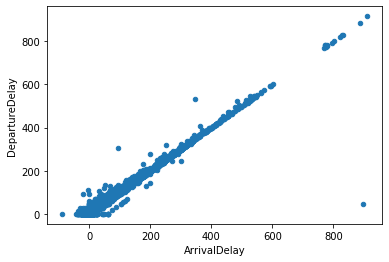

In [17]:
df.plot.scatter(x="ArrivalDelay", y="DepartureDelay")

From the above plot, we see `Departure Delay` is highly co-related with `ArrivalDelay` in general. Also, the plot points out few data-points which for which is `ArrivalDelay` is very high (>400) but, `DepartureDelay` is very small. They look like anomalies. Let's look into this data-points.   

In [18]:
df.loc[(df["ArrivalDelay"]>850) & (df["DepartureDelay"]<100), 
       ["ArrivalDelay", "DepartureDelay", "actualArrival", 
        "actualDeparture", "scheduledArrival", "scheduledDeparture"]]

,ArrivalDelay,DepartureDelay,actualArrival,actualDeparture,scheduledArrival,scheduledDeparture
12423,898.0,45.0,2020-01-02 06:13:00,2020-01-02 16:05:00,2020-01-02 13:05:00,2020-01-02 13:10:00


As we can see, this is data acquisition error. Such instances presses for the need of checking the data and removing errorneous data.

In [19]:
df["calculatedArrivalDelay"] = (pd.DatetimeIndex(df['actualArrival']) - pd.DatetimeIndex(df['scheduledArrival'])).astype('timedelta64[m]')

df.loc[(df["calculatedArrivalDelay"].notnull()) & (df["calculatedArrivalDelay"] != df["ArrivalDelay"]), 
       ["calculatedArrivalDelay", "ArrivalDelay", "scheduledArrival", "actualArrival"]]

,calculatedArrivalDelay,ArrivalDelay,scheduledArrival,actualArrival
45,-1315.0,125.0,2020-01-03 23:59:00,2020-01-03 02:04:00
99,-1266.0,174.0,2020-01-04 23:59:00,2020-01-04 02:53:00
153,-1306.0,134.0,2020-01-05 23:59:00,2020-01-05 02:13:00
207,-1318.0,122.0,2020-01-06 23:59:00,2020-01-06 02:01:00
261,-1229.0,211.0,2020-01-07 23:59:00,2020-01-07 03:30:00
...,...,...,...,...
31680,22.0,12.0,2020-02-15 10:01:00,2020-02-15 10:23:00
31724,185.0,175.0,2020-02-16 10:01:00,2020-02-16 13:06:00
31768,40.0,30.0,2020-02-17 10:01:00,2020-02-17 10:41:00
31812,18.0,8.0,2020-02-19 10:01:00,2020-02-19 10:19:00


In [20]:
df["calculatedDepartureDelay"] = (pd.DatetimeIndex(df['actualDeparture']) 
       ["calculatedDepartureDelay", "DepartureDelay", 
        "scheduledDeparture", "actualDeparture"]].sort_values(by="calculatedDepartureDelay")

,calculatedDepartureDelay,DepartureDelay,scheduledDeparture,actualDeparture
31511,-20.0,0.0,2020-02-11 15:15:00,2020-02-11 14:55:00
30499,-19.0,1.0,2020-01-13 15:15:00,2020-01-13 14:56:00
31819,-19.0,1.0,2020-02-19 15:15:00,2020-02-19 14:56:00
30279,-19.0,1.0,2020-01-07 15:15:00,2020-01-07 14:56:00
30411,-19.0,1.0,2020-01-11 15:15:00,2020-01-11 14:56:00
...,...,...,...,...
19300,538.0,527.0,2020-01-11 23:44:00,2020-01-12 08:42:00
19301,540.0,529.0,2020-01-12 00:14:00,2020-01-12 09:14:00
19304,551.0,522.0,2020-01-12 02:21:00,2020-01-12 11:32:00
19303,554.0,535.0,2020-01-12 01:51:00,2020-01-12 11:05:00


There are 3740 errorneous samples related to arrival delays, and 2054 samples related to departure delays.

The errors include but are not limited to:

- Outdated schedules where `scheduledArrival` and `scheduledDeparture` are wrong, but listed delays are correct.
- Wrong delay calculation.
- Error in recording the dates when `actualArrival` or `actualDepature` is on the next day, relative to their scheduled timings.  

**Assumption** - Although, these mistakes can be rectified programatically by putting multiple heruristics, I will choose to drop these rows for the first model considering time constraints.

### Drop erroneous data

In [21]:
idx_erroneous = df[((df["calculatedDepartureDelay"].notnull()) & 
       (df["calculatedDepartureDelay"] != df["DepartureDelay"])) |
   ((df["calculatedArrivalDelay"].notnull()) & 
    (df["calculatedArrivalDelay"] != df["ArrivalDelay"]))
  ].index

#### Is there any (station, train) pair which was completely removed as a part of erroneous data?

In [22]:
df.loc[idx_erroneous, ["stations", "trainCode"]].drop_duplicates()

,stations,trainCode
45,JL,12138
2674,WR,12139
4718,KJM,12295
4720,KPN,12295
4732,BPQ,12295
...,...,...
28361,BALU,12840
28365,JJKR,12840
28369,SRC,12840
30052,NZM,12925


In [347]:
ts_remove = df.loc[idx_erroneous, ["stations", "trainCode"]].drop_duplicates()
ts_remove.to_csv("ts_remove.csv", sep=",", index=False)

**Assumption** - There are 89 (train, station) pairs which will get removed as a part of removal of erroneous data. We will record these pairs for now, and won't be doing the prediction task for such pairs or may create a different or a seperate model which can handle samples corresponding to these pairs.

In [24]:
df.drop(idx_erroneous, inplace=True)
print(df.isnull().sum(axis=0))

runDate                       0
stations                      0
trainCode                     0
scheduledArrival            644
scheduledDeparture          760
actualArrival               644
actualDeparture             760
distance                      0
dayCount                      0
ArrivalDelay                644
DepartureDelay              760
month                         0
hourDeparture               760
minuteDeparture             760
hourArrival                 644
minuteArrival               644
calculatedArrivalDelay      644
calculatedDepartureDelay    760
dtype: int64


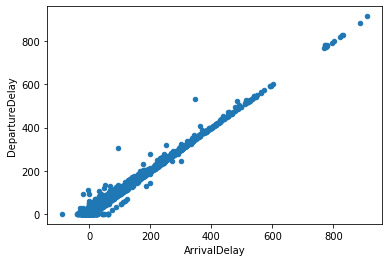

In [25]:
df.plot.scatter(x="ArrivalDelay", y="DepartureDelay")

### Understanding Outliers

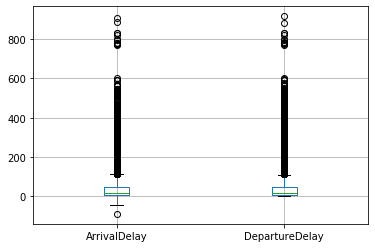

In [349]:
df.boxplot(column=['ArrivalDelay', 'DepartureDelay'])

These box-plots points-out the presence of outliers in the data.

### Outlier Detection

#### Outlier Detection using IQR method

In [26]:
ts_Q1 = df.groupby(['trainCode', "stations"])['ArrivalDelay'].quantile(0.25).reset_index().rename(columns={'ArrivalDelay':'Q1'})
ts_Q3 = df.groupby(['trainCode', "stations"])['ArrivalDelay'].quantile(0.75).reset_index().rename(columns={'ArrivalDelay':'Q3'})
ts = ts_Q1.merge(ts_Q3, on=["trainCode", "stations"])
ts_median = df.groupby(['trainCode', "stations"])['ArrivalDelay'].median().reset_index().rename(columns={'ArrivalDelay':'MedianArrivalDelay'})
ts = ts.merge(ts_median, on=["trainCode", "stations"])
ts["IQR"] = ts["Q3"] - ts["Q1"]
ts["UpperArrivalDelay"] = ts["Q3"] + 1.5*ts["IQR"]
ts["LowerArrivalDelay"] = ts["Q1"] - 1.5*ts["IQR"]
df = df.merge(ts, on=['trainCode', "stations"])

print(df.loc[df["ArrivalDelay"] > df["UpperArrivalDelay"], ["stations", "trainCode"]].drop_duplicates().shape)

outlier_counts = df.loc[df["ArrivalDelay"] > df["UpperArrivalDelay"]]\
    .groupby(["stations", "trainCode"])\
    .size().reset_index(name='delay_count')

print("Mode outlier count", outlier_counts["delay_count"].mode()[0])
print("Median outlier count", outlier_counts["delay_count"].median())

(563, 2)
Mode outlier count 1
Median outlier count 3.0


The **The mode of outlier counts for (train, station) pairs is 1**. This signifies that for most of the (train, station) pairs, such intances have happened only once which we can consider as noise, and for the cases where the frequency count is >= 3 (median outlier count), we would choose those cases to be explicitly modelled by design, and we will create a boolean feature to mark such (train, station) pairs.

#### Outlier Detection using 95% or 98% percentile

In [27]:
ts_95 = df.groupby(['trainCode', "stations"])['ArrivalDelay'].quantile(0.95).reset_index().rename(columns={'ArrivalDelay':'q95'})
df = df.merge(ts_95, on=['trainCode', "stations"])

outlier_df = df.loc[df["ArrivalDelay"] > df["q95"]]\
    .groupby(["stations", "trainCode"])\
    .size().reset_index(name='counts')

print("Mode outlier count", outlier_df["counts"].mode()[0])
print("Median outlier count", outlier_df["counts"].median())

Mode outlier count 3
Median outlier count 3.0


The outlier detection method using 0.95 quantile or 95 percentile seem to be catching more instances with repeated delays. Out of 618 total (train, station) pairs, 604 were marked as to having outliers.

**Assumption** - We will use IQR method to detect the outliers, and mark those (train, station) pairs with a new boolean variables which have 3 or more instances of such outliers.

### Distance v/s ArrivalDelay/DepartureDelay

#### Total length of the train vs average delay of the train

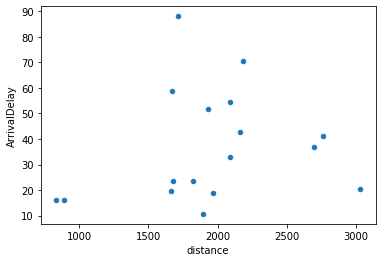

In [28]:
x = df.groupby('trainCode')['ArrivalDelay'].mean().reset_index().sort_values(by="ArrivalDelay")
y = df.loc[df["scheduledDeparture"].isnull(), ["trainCode", "distance"]].drop_duplicates().sort_values(by="distance")
pd.merge(x,y, on='trainCode').plot.scatter(x="distance", y="ArrivalDelay")

It doesn't seem to be any relation between time of journey and the delay time.

### Trainwise Distance V/S AvgArrivalDelay 

trainCode
12138    AxesSubplot(0.125,0.125;0.775x0.755)
12139    AxesSubplot(0.125,0.125;0.775x0.755)
12295    AxesSubplot(0.125,0.125;0.775x0.755)
12311    AxesSubplot(0.125,0.125;0.775x0.755)
12321    AxesSubplot(0.125,0.125;0.775x0.755)
12616    AxesSubplot(0.125,0.125;0.775x0.755)
12617    AxesSubplot(0.125,0.125;0.775x0.755)
12625    AxesSubplot(0.125,0.125;0.775x0.755)
12656    AxesSubplot(0.125,0.125;0.775x0.755)
12722    AxesSubplot(0.125,0.125;0.775x0.755)
12809    AxesSubplot(0.125,0.125;0.775x0.755)
12833    AxesSubplot(0.125,0.125;0.775x0.755)
12834    AxesSubplot(0.125,0.125;0.775x0.755)
12840    AxesSubplot(0.125,0.125;0.775x0.755)
12925    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

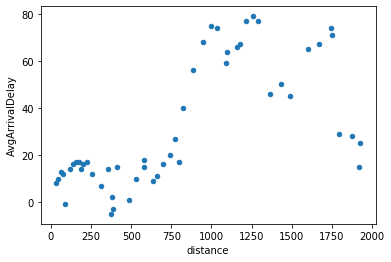

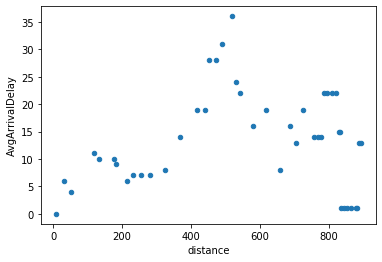

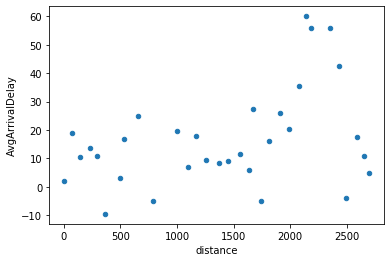

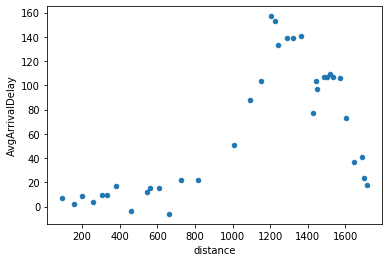

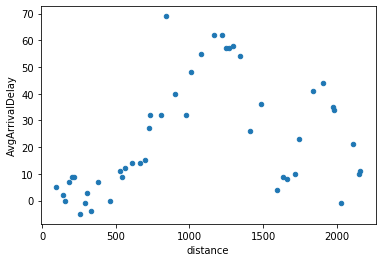

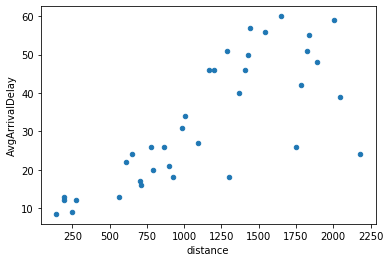

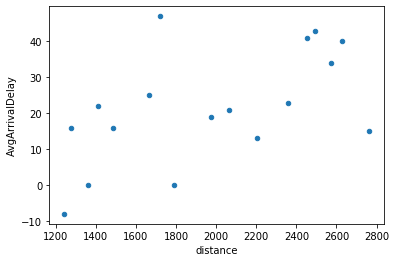

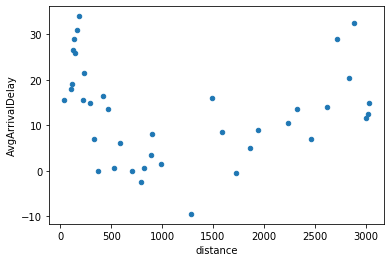

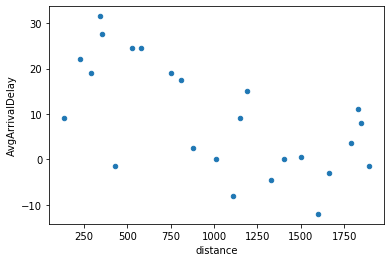

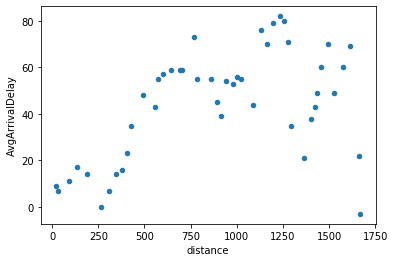

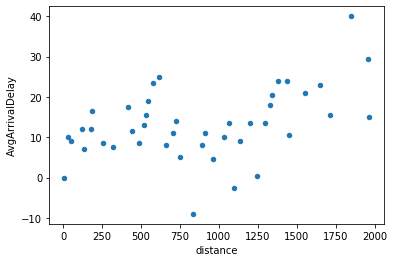

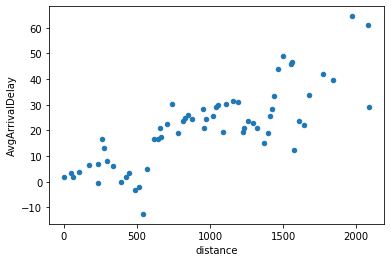

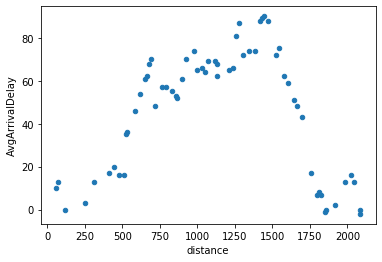

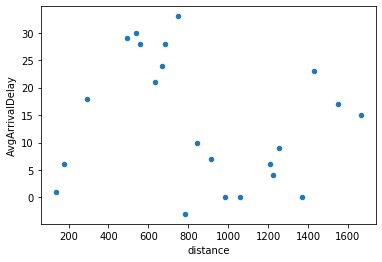

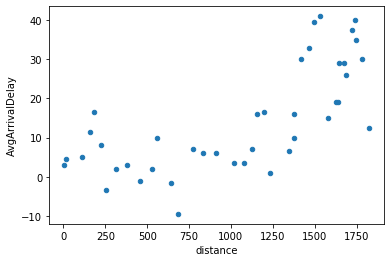

In [65]:
df.groupby(['trainCode', 'distance'])['ArrivalDelay'].median().reset_index(name="AvgArrivalDelay")\
.groupby('trainCode')\
.plot.scatter(x="distance", y="AvgArrivalDelay")

### Trainwise arrival delay patterns across different days of the week

trainCode
12138    AxesSubplot(0.125,0.125;0.775x0.755)
12139    AxesSubplot(0.125,0.125;0.775x0.755)
12295    AxesSubplot(0.125,0.125;0.775x0.755)
12311    AxesSubplot(0.125,0.125;0.775x0.755)
12321    AxesSubplot(0.125,0.125;0.775x0.755)
12616    AxesSubplot(0.125,0.125;0.775x0.755)
12617    AxesSubplot(0.125,0.125;0.775x0.755)
12625    AxesSubplot(0.125,0.125;0.775x0.755)
12656    AxesSubplot(0.125,0.125;0.775x0.755)
12722    AxesSubplot(0.125,0.125;0.775x0.755)
12809    AxesSubplot(0.125,0.125;0.775x0.755)
12833    AxesSubplot(0.125,0.125;0.775x0.755)
12834    AxesSubplot(0.125,0.125;0.775x0.755)
12840    AxesSubplot(0.125,0.125;0.775x0.755)
12925    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

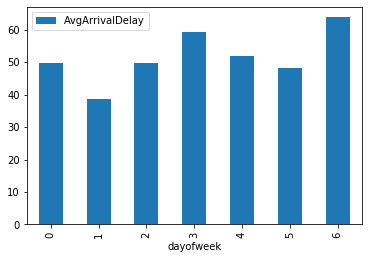

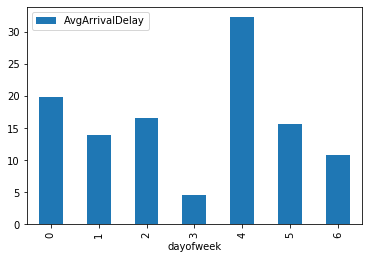

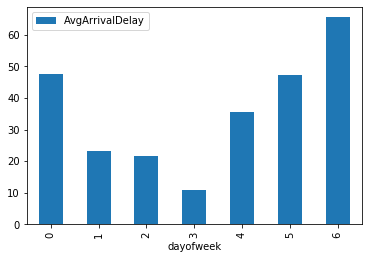

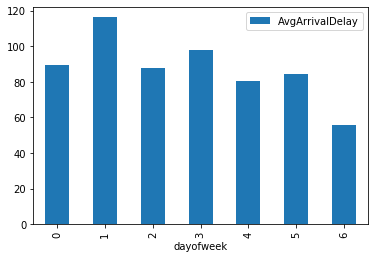

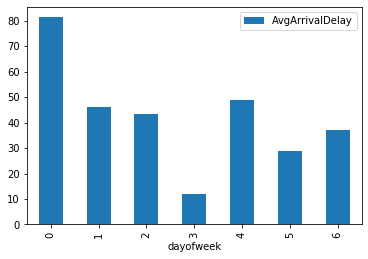

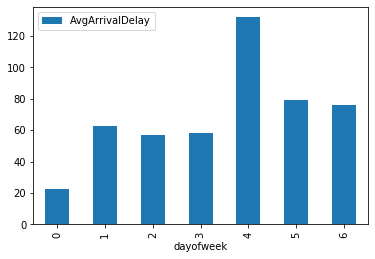

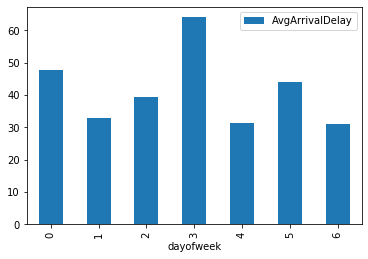

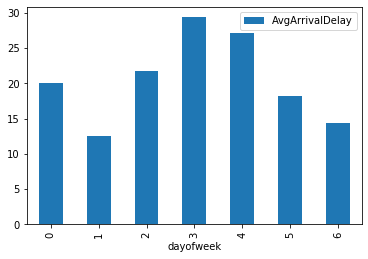

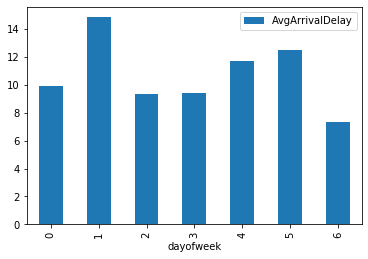

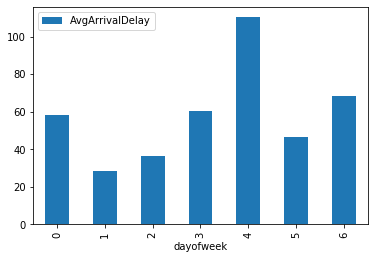

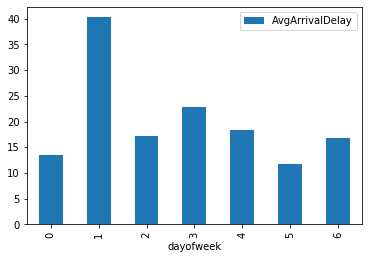

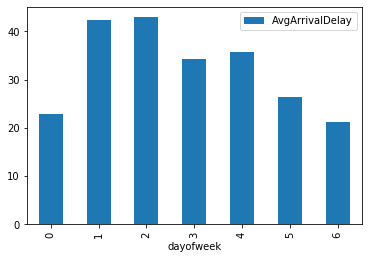

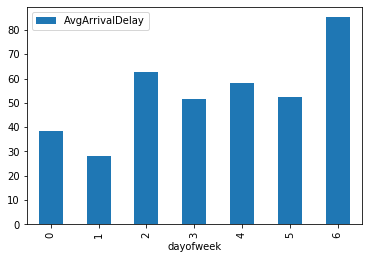

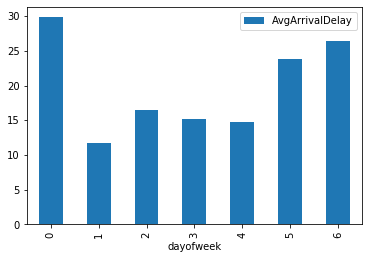

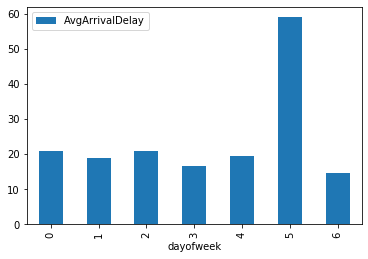

In [78]:
df["dayofweek"] = pd.DatetimeIndex(df['runDate']).dayofweek.astype("category")
df.groupby(["dayofweek", "trainCode"])['ArrivalDelay'].mean()\
.reset_index(name="AvgArrivalDelay").groupby(["trainCode"]).plot.bar(x="dayofweek", y="AvgArrivalDelay")

In [66]:
# import pandas as pd
# from sklearn.datasets import load_iris
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# delay_data = o_df[['ArrivalDelay', 'DepartureDelay']]

# sse = {}
# for k in range(1, 20):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(delay_data)
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()